# Using Genetic Programming to fit a function to noisy data.

DEAP install

In [4]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 6.0 MB/s 


Let's make a noisy signal.

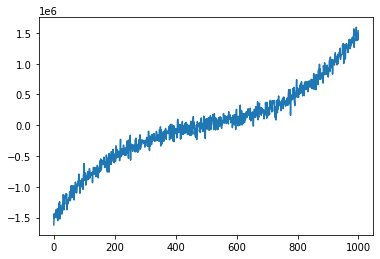

In [101]:
import numpy as np
from matplotlib import pyplot as plt

def generate_noisy_data(**kwargs):
    """
    Given a function f
    Generate some noisy data 
    By adding noise to the output of that function
    """
    y = cubic(**kwargs)
    noisy_y = noise(y)
    return noisy_y

def cubic(x,a,b,c,d):
    """
    a cubic function.
    """
    return a*x**3 + b*x**2 + c*x + d

def noise(x):
    """
    Add noise to a given input.
    Noise magnitude is 
    ~ N(0,max(x)/10)
    I.e scales with input magnitude
    """
    l = len(x)
    return x + (1/20 * max(x)) * np.random.randn(l)

x_vec=np.linspace(-100,100,1000)
constants={'a':1,'b':1,'c':int(5e3),'d':0}
y_vec=generate_noisy_data(x=x_vec,a=constants['a'], b=constants['b'], c=constants['c'], d=constants['d'])
plt.plot(y_vec)
plt.show()

Now lets make a function to fit this.

In [117]:
import operator
import math
import random
from sympy import sympify
import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from matplotlib import pyplot as plt

def protectedDiv(a, b):
    """
    protected division for numpy arrays
    """
    c = np.divide(a, b, out=np.ones_like(a), where=b!=0)
    return c

def evalSymbReg(individual,x_points,y_points):
    """evaluate the fitness of the individual"""
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression and
    # the real values (y points)
    sqerrors = ((func(x_points[i]) - y_points[i])**2 for i in range(len(x_points)))
    mean_err = math.fsum(sqerrors) / len(x_points)
    return mean_err,

def create_primset(name):
    #create primitive set
    pset = gp.PrimitiveSet("MAIN", 1)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    #pset.addPrimitive(protectedDiv, 2)
    #pset.addPrimitive(math.cos,1)
    #pset.addPrimitive(math.sin,1)
    # deap bug: must change randguy string every time.. (raise github issue?)
    pset.addEphemeralConstant(name, lambda: random.randint(-2,2))
    #use x instead of ARG0 as our variable name
    pset.renameArguments(ARG0='x')
    return pset    

def create_stats():
    #create tools for computing statistics on populations
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    return mstats

def human_readable(individual):
    """ convert a candidate function into a human readable string""" 
    #dictionary to translate deap output to human readable
    #using sympy
    locals = {
        'sub': lambda x, y : x - y,
        'protectedDiv': lambda x, y : x/y if y!=0 else 1,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'pow': lambda x, y : x**y,
        'neg': lambda x    : -x,
    }

    print(f'original: {individual}')
    expr = sympify(str(individual) , locals=locals)
    print(f'simplified: {expr}')
    return expr

def create_toolbox(pset,tree_depth):
    """given a pset, create a toolbox to operate while evolving"""
    #define evolution parameters with toolbox
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    #evaluate performance
    toolbox.register("evaluate", evalSymbReg, x_points=x_vec, y_points=y_vec)
    #use double tournament selection to select first based on fitness, and second based on size.
    toolbox.register("select", tools.selDoubleTournament, fitness_size=4, parsimony_size=1.4, fitness_first=True)
    #toolbox.register("select", tools.selTournament, tournsize=4)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=tree_depth))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=tree_depth))
    return toolbox

def plot_comparison(x_vec,y_vec,func,titstr):
    """compare a function's prediction with the real points"""
    x_vec = np.asarray(x_vec)
    pred = [func(i) for i in x_vec]
    plt.plot(x_vec,y_vec,label="realdata")
    plt.plot(x_vec,pred,label="prediction")
    plt.title(f"{titstr}\n Guessed ${best_str}$")
    plt.legend()
    plt.show()

Run it!

Enter number of individuals per generation: 10000
Enter number of generations: 10
Enter max depth of syntax tree (controls complexity of functions): 20
Enter a random seed int: 123
X vector [-100.          -99.7997998   -99.5995996   -99.3993994   -99.1991992
  -98.998999    -98.7987988   -98.5985986   -98.3983984   -98.1981982
  -97.997998    -97.7977978   -97.5975976   -97.3973974   -97.1971972
  -96.996997    -96.7967968   -96.5965966   -96.3963964   -96.1961962
  -95.995996    -95.7957958   -95.5955956   -95.3953954   -95.1951952
  -94.99499499  -94.79479479  -94.59459459  -94.39439439  -94.19419419
  -93.99399399  -93.79379379  -93.59359359  -93.39339339  -93.19319319
  -92.99299299  -92.79279279  -92.59259259  -92.39239239  -92.19219219
  -91.99199199  -91.79179179  -91.59159159  -91.39139139  -91.19119119
  -90.99099099  -90.79079079  -90.59059059  -90.39039039  -90.19019019
  -89.98998999  -89.78978979  -89.58958959  -89.38938939  -89.18918919
  -88.98898899  -88.78878879  -88.

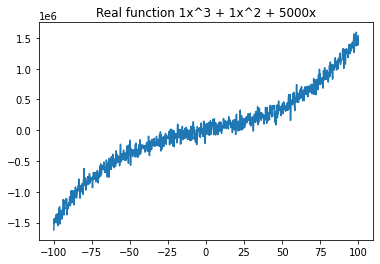

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg       	gen	max        	min        	nevals	std        	avg   	gen	max	min	nevals	std    
0  	10000 	1.5487e+12	0  	1.12018e+15	3.20653e+10	10000 	3.53919e+13	4.5914	0  	7  	3  	10000 	1.82752
1  	2820  	9.82207e+11	1  	1.12103e+15	3.20622e+10	2820  	2.50354e+13	4.497 	1  	13 	1  	2820  	2.00604
2  	2864  	2.42122e+12	2  	4.4811e+15 	3.20088e+10	2864  	8.22809e+13	4.8646	2  	19 	1  	2864  	2.15733
3  	2761  	8.27602e+15	3  	3.67404e+19	3.20088e+10	2761  	5.27434e+17	5.8338	3  	19 	1  	2761  	2.17043
4  	2795  	8.30312e+15	4  	3.67437e+19	3.20158e+10	2795  	4.20812e+17	6.5598	4  	23 	1  	2795  	1.9449 
5  	2838  	3.89711e+19	5  	3.11401e+23	3.20158e+10	2838  	3.20961e+21	6.8748	5  	19 	1  	2838  	1.78693
6  	

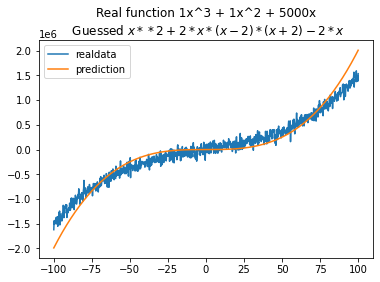

In [119]:
from random import randint as rand

generation_pop = int(input("Enter number of individuals per generation: "))
gen_num = int(input("Enter number of generations: "))
depth = int(input("Enter max depth of syntax tree (controls complexity of functions): "))
r = int(input("Enter a random seed int: "))

#load our x and y points
print("X vector", x_vec, "size", len(x_vec))
print("Y vector", y_vec, "size", len(y_vec))
plt.plot(x_vec, y_vec)
titstr = f"Real function {constants['a']}x^3 + {constants['b']}x^2 + {constants['c']}x"
plt.title(titstr)
plt.show()

#create primitive set of operations for tree generation
randname = str(100*rand(0,100) + 123*rand(0,100))+"name"
#need new name for randon number constant each time due to DEAP bug
pset = create_primset(randname)

#define fitness function and create individual who holds the genotype
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#individual is a tree
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#define evolution parameters with toolbox
toolbox = create_toolbox(pset,depth) 

#------------------------------------------
#run it
random.seed(r)

pop = toolbox.population(n=generation_pop)
hof = tools.HallOfFame(1)

#grab statistics
mstats = create_stats()

#eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,halloffame=None, verbose=__debug__):
"""This algorithm implements a simple evolutionary algorithm
:param population: A list of individuals.
:param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution operators.
:param cxpb: The probability of mating two individuals. Set to 20%
:param mutpb: The probability of mutating an individual. Set to 10%
:param ngen: The number of generation.
:param stats: A :class:`~deap.tools.Statistics` object 
:param halloffame: A :class:`~deap.tools.HallOfFame` object that will contain the best individuals, optional.
:param verbose: Whether or not to log the statistics.
:returns: population: The final population
:returns: run_log: statistics of the evolution process
"""
population, run_log = algorithms.eaSimple(pop, toolbox, 0.2, 0.1, gen_num, stats=mstats,
                                halloffame=hof, verbose=True)
print(run_log)

#try to get best individual into a printable form
best_ind = tools.selBest(population, 1)[0]
best_str = human_readable(best_ind)
print("best str", best_str)

#now plot the function vs the data
func = toolbox.compile(expr=best_ind)
#save plot
plot_comparison(x_vec,y_vec,func,titstr)